In [ ]:
%pip install --upgrade keras

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import keras

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


####Loading Data

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# normalize images
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

In [ ]:
import jax
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]

####Base Model = (Dense, 256,sigmoid)-(Dense,256,sigmoid)-(Dense,10,softmax)
####Compilation = {optimizer= 'SGD', loss = 'sparse_categorical_crossentropy',   metrics = ['accuracy'] }
####Fitting = {batch_size=64, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_0= keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(256, activation='sigmoid',name='dense_1'),
     layers.Dense(256, activation='sigmoid',name='dense_2'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

#
model_0.compile(optimizer= 'SGD',
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_0 = model_0.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_split = 0.2)

model_0.save('FCNN_Base_Model.keras')

Epoch 1/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1434 - loss: 2.2888 - val_accuracy: 0.2064 - val_loss: 2.2636
Epoch 2/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.2105 - loss: 2.2399 - val_accuracy: 0.1947 - val_loss: 2.2142
Epoch 3/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.2414 - loss: 2.1800 - val_accuracy: 0.2680 - val_loss: 2.1460
Epoch 4/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.2646 - loss: 2.1146 - val_accuracy: 0.2708 - val_loss: 2.0872
Epoch 5/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.2762 - loss: 2.0617 - val_accuracy: 0.2949 - val_loss: 2.0426
Epoch 6/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - accuracy: 0.2890 - loss: 2.0210 - val_accuracy: 0.2949 - val_loss: 2.0087
Epoch 7/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2981 - loss: 1.9890 - val_accuracy: 0.2941 - val_loss: 1.9809
Epoch 8/100
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3043 - loss: 1.9635 

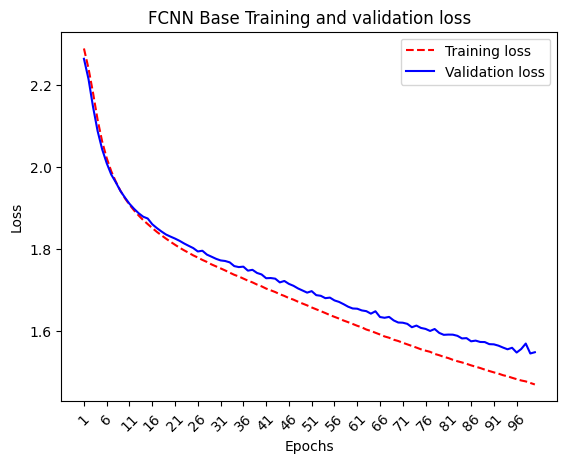

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_0.history["loss"]
val_loss = history_0.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Base Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Base Model Notes: Training curve looks normal but loss is still high and  accuracy low, lets increase complexity by increasing number of neurons per layer to 512

In [ ]:
model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 855,052 (3.26 MB)

 Trainable params: 855,050 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

#Incremental Experiments

###Variant 1 = (Dense, 512,sigmoid)-(Dense,512,sigmoid)-(Dense,10,softmax)
###Compilation = {optimizer= 'SGD', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=64, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_1 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(512, activation='sigmoid',name='dense_1'),
     layers.Dense(512, activation='sigmoid',name='dense_2'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

#
model_1.compile(optimizer= 'SGD', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']
                 #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_1 = model_1.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split = 0.2)

model_1.save('FCNN_Variant_1.keras')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1433 - loss: 2.2803 - val_accuracy: 0.2123 - val_loss: 2.2460
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.2055 - loss: 2.2165 - val_accuracy: 0.2289 - val_loss: 2.1859
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.2399 - loss: 2.1455 - val_accuracy: 0.2490 - val_loss: 2.1110
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.2653 - loss: 2.0810 - val_accuracy: 0.2820 - val_loss: 2.0535
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.2812 - loss: 2.0312 - val_accuracy: 0.2865 - val_loss: 2.0130
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.2904 - loss: 1.9947 - val_accuracy: 0.2920 - val_loss: 1.9818
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.3005 - loss: 1.9656 - val_accuracy: 0.2949 - val_loss: 1.9596
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.3099 - loss: 1.9430 - va

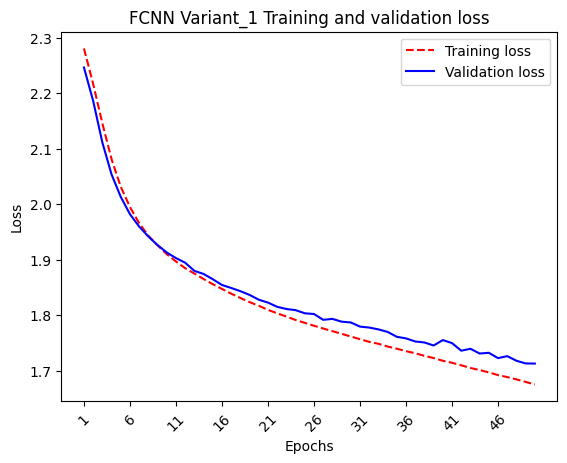

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_1.history["loss"]
val_loss = history_1.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant_1 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 1 Observation: Increasing the numbr of neurons per hidden layer from 256 to 512 did not cause significant decrease in loss so we change number of neurons back to 256 and change activation function to relu

In [ ]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,841,164 (7.02 MB)

 Trainable params: 1,841,162 (7.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

####Variant 2 = (Dense, 256,relu)-(Dense,256,relu)-(Dense,10,softmax)
####Compilation = {optimizer= 'SGD', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
####Fitting = {batch_size=64, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_2 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(256, activation='relu',name='dense_1'),
     layers.Dense(256, activation='relu',name='dense_2'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

#
model_2.compile(optimizer= 'SGD',
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_2 = model_2.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split = 0.2)

model_2.save('FCNN_Variant_2.keras')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3047 - loss: 1.9495 - val_accuracy: 0.3430 - val_loss: 1.8537
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.3729 - loss: 1.7752 - val_accuracy: 0.3517 - val_loss: 1.8195
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.3962 - loss: 1.7011 - val_accuracy: 0.3892 - val_loss: 1.7270
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4183 - loss: 1.6470 - val_accuracy: 0.4221 - val_loss: 1.6475
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.4327 - loss: 1.6068 - val_accuracy: 0.4303 - val_loss: 1.6249
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.4467 - loss: 1.5720 - val_accuracy: 0.4338 - val_loss: 1.6069
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4541 - loss: 1.5428 - val_accuracy: 0.4354 - val_loss: 1.6073
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.4637 - loss: 1.5177 - val_ac

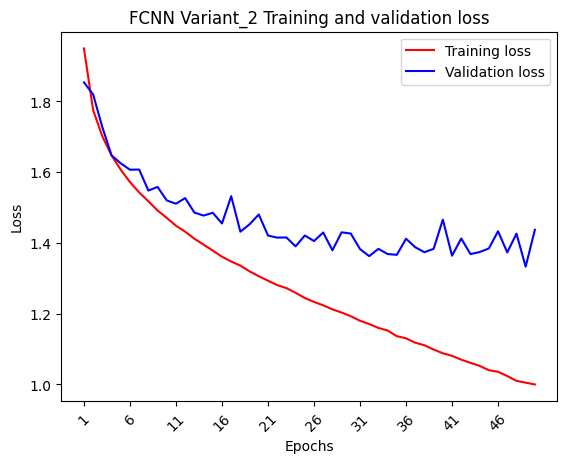

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_2.history["loss"]
val_loss = history_2.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant_2 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


In [ ]:
model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 855,052 (3.26 MB)

 Trainable params: 855,050 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

#### Variant 3 = (Dense, 256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,10,softmax)
####Compilation = {optimizer= 'SGD', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
####Fitting = {batch_size=64, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_3 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(256, activation='relu',name='dense_1'),
     layers.Dense(256, activation='relu',name='dense_2'),
     layers.Dense(256, activation='relu',name='dense_3'),
     layers.Dense(256, activation='relu',name='dense_4'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

#
model_3.compile(optimizer= 'SGD',
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_3 = model_3.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split = 0.2)

model_3.save('FCNN_Variant_3.keras')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2718 - loss: 2.0214 - val_accuracy: 0.3300 - val_loss: 1.8756
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.3559 - loss: 1.8159 - val_accuracy: 0.3643 - val_loss: 1.7778
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.3846 - loss: 1.7337 - val_accuracy: 0.3885 - val_loss: 1.7271
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.4055 - loss: 1.6722 - val_accuracy: 0.3845 - val_loss: 1.7329
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.4253 - loss: 1.6193 - val_accuracy: 0.4224 - val_loss: 1.6234
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4396 - loss: 1.5814 - val_accuracy: 0.4381 - val_loss: 1.5896
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.4488 - loss: 1.5451 - val_accuracy: 0.4294 - val_loss: 1.6089
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.4588 - loss: 1.5145 - val_

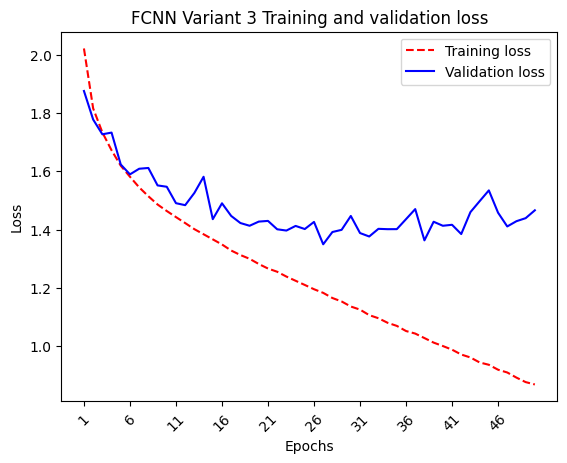

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_3.history["loss"]
val_loss = history_3.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 3 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 3 Notes: Overall, training loss and accuracy has improved but point of robust fit is coming too early. For the next model, we keep architecture the same and use SGD with momentum

In [ ]:
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,636 (3.76 MB)

 Trainable params: 986,634 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (8.00 B)

### Variant 4 = (Dense, 256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,10,softmax)
###Compilation = {optimizer= 'SGD with 0.5 momentum', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=64, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_4 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
      layers.Dense(256, activation='relu',name='dense_1'),
     layers.Dense(256, activation='relu',name='dense_2'),
     layers.Dense(256, activation='relu',name='dense_3'),
     layers.Dense(256, activation='relu',name='dense_4'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

opt = keras.optimizers.SGD(momentum=0.5)
model_4.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_4 = model_4.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split = 0.2)

model_4.save('FCNN_Variant_4.keras')

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3004 - loss: 1.9425 - val_accuracy: 0.3533 - val_loss: 1.8098
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3804 - loss: 1.7297 - val_accuracy: 0.3905 - val_loss: 1.7122
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.4154 - loss: 1.6388 - val_accuracy: 0.4162 - val_loss: 1.6431
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4391 - loss: 1.5750 - val_accuracy: 0.4390 - val_loss: 1.5810
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.4549 - loss: 1.5250 - val_accuracy: 0.4466 - val_loss: 1.5726
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.4715 - loss: 1.4838 - val_accuracy: 0.4343 - val_loss: 1.5970
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.4814 - loss: 1.4479 - val_accuracy: 0.4575 - val_loss: 1.5161
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.4931 - loss: 1.4198 - val_ac

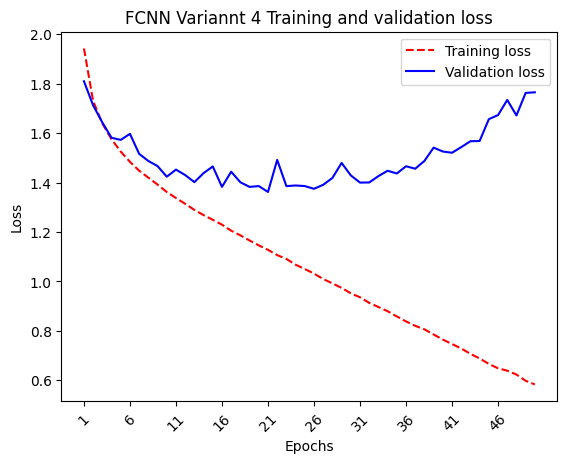

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_4.history["loss"]
val_loss = history_4.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variannt 4 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 4 Notes: Overall Training performance is higher but overfitting is worse.Next, we increase batch size from 64 to 128, hoping  to reduce variance and make loss smooth, we play with it to find the best value and them move to the next variant

In [ ]:
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,973,270 (7.53 MB)

 Trainable params: 986,634 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,636 (3.76 MB)

### Variant 5 = (Dense, 256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,10,softmax)
###Compilation = {optimizer= 'SGD with 0.5 momentum and learning rate',loss='sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_5 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(256, activation='relu',name='dense_1'),
     layers.Dense(256, activation='relu',name='dense_2'),
     layers.Dense(256, activation='relu',name='dense_3'),
     layers.Dense(256, activation='relu',name='dense_4'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)

opt = keras.optimizers.SGD(momentum=0.5)
model_5.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_5 = model_5.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_5.save('FCNN_Variant_5.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2743 - loss: 2.0092 - val_accuracy: 0.3233 - val_loss: 1.8701
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3556 - loss: 1.8035 - val_accuracy: 0.3275 - val_loss: 1.8791
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3862 - loss: 1.7168 - val_accuracy: 0.3531 - val_loss: 1.8014
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4097 - loss: 1.6555 - val_accuracy: 0.4109 - val_loss: 1.6458
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.4315 - loss: 1.6025 - val_accuracy: 0.4037 - val_loss: 1.6896
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.4421 - loss: 1.5681 - val_accuracy: 0.4383 - val_loss: 1.5792
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4556 - loss: 1.5343 - val_accuracy: 0.4502 - val_loss: 1.5575
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4665 - loss: 1.4991 - val_accuracy

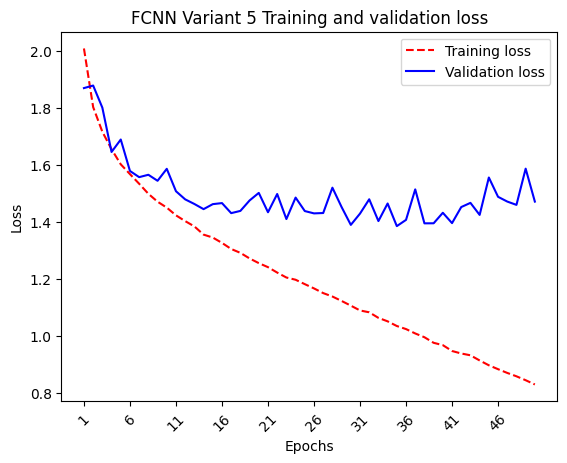

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_5.history["loss"]
val_loss = history_5.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 5 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 5 notes: Overfitting reduced but loss curve is still noisy indicating learning rate is too high. Training performance also dropped. Instead of changing the learning late, we experiment with optimizers that implement adaptive learning rate.

In [ ]:
model_5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,973,270 (7.53 MB)

 Trainable params: 986,634 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,636 (3.76 MB)

### Variant 6 = (Dense, 256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,256,relu)-(Dense,10,softmax)
###Compilation = {optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_6 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),
     layers.Dense(256, activation='relu',name='dense_1'),
     layers.Dense(256, activation='relu',name='dense_2'),
     layers.Dense(256, activation='relu',name='dense_3'),
     layers.Dense(256, activation='relu',name='dense_4'),
     layers.Dense(10, activation='softmax',name='preds')
     ]
)


opt = keras.optimizers.RMSprop()
model_6.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_6 = model_6.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_6.save('FCNN_Variant_6.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2398 - loss: 2.0599 - val_accuracy: 0.3006 - val_loss: 1.9447
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3318 - loss: 1.8416 - val_accuracy: 0.3494 - val_loss: 1.7965
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3668 - loss: 1.7569 - val_accuracy: 0.3111 - val_loss: 1.9015
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3929 - loss: 1.6877 - val_accuracy: 0.3694 - val_loss: 1.7518
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4102 - loss: 1.6344 - val_accuracy: 0.4038 - val_loss: 1.6808
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4270 - loss: 1.5940 - val_accuracy: 0.4137 - val_loss: 1.6315
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4405 - loss: 1.5550 - val_accuracy: 0.4272 - val_loss: 1.6287
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4562 - loss: 1.5166 - val_accuracy: 0.

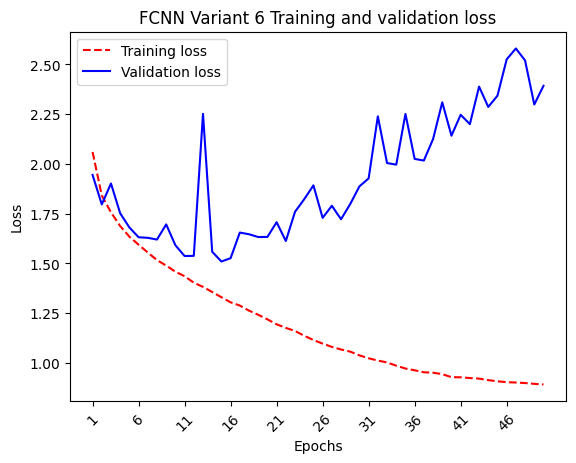

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_6.history["loss"]
val_loss = history_6.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 6 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 6 notes: Training performance improved, but overfitting became worse and validation is unstable. Validation loss is still noisy, its increasing nature indicates exploding gradients a possible outcome of all hidden activation fucntions being RELU. Next, we try to stop exploding gradients using batch normalization

In [ ]:
model_6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,973,270 (7.53 MB)

 Trainable params: 986,634 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 986,636 (3.76 MB)

### Variant 7 = (Dense, 256,batchnorm,relu)-(Dense,256,batchnorm,relu)-(Dense,256,batchnorm,relu)-(Dense,256,batchnorm,relu)-(Dense,10,softmax)
###Compilation = {optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_7 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),

     layers.Dense(256,name='dense_1'),
     layers.BatchNormalization(name='bn_1'),
     layers.ReLU(name='relu_1'),

     layers.Dense(256,name='dense_2'),
     layers.BatchNormalization(name='bn_2'),
     layers.ReLU(name='relu_2'),

     layers.Dense(256,name='dense_3'),
     layers.BatchNormalization(name='bn_3'),
     layers.ReLU(name='relu_3'),

     layers.Dense(256,name='dense_4'),
     layers.BatchNormalization(name='bn_4'),
     layers.ReLU(name='relu_4'),

     layers.Dense(10, activation='softmax',name='preds')
     ]
)


opt = keras.optimizers.RMSprop()
model_7.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_7 = model_7.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_7.save('FCNN_Variant_7.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.3998 - loss: 1.6743 - val_accuracy: 0.2708 - val_loss: 2.2912
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4903 - loss: 1.4209 - val_accuracy: 0.3320 - val_loss: 1.9914
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5372 - loss: 1.2895 - val_accuracy: 0.3791 - val_loss: 1.9735
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5775 - loss: 1.1877 - val_accuracy: 0.4078 - val_loss: 1.8533
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6068 - loss: 1.0997 - val_accuracy: 0.4284 - val_loss: 1.7340
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 1.0155 - val_accuracy: 0.4127 - val_loss: 1.8852
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 0.9432 - val_accuracy: 0.4378 - val_loss: 1.7915
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6908 - loss: 0.8673 - val_accuracy: 0.

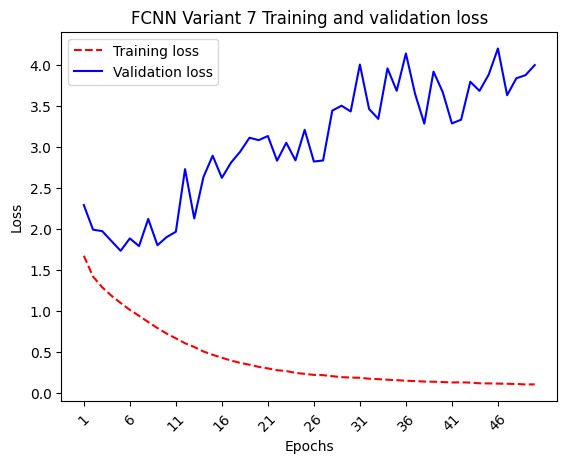

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_7.history["loss"]
val_loss = history_7.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 7 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 7 notes: with Batchnormalization, model memorized training data but genenralized very poorly. Next, we implement dropout as a regularization technique to all hidden layers

In [ ]:
model_7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,979,414 (7.55 MB)

 Trainable params: 988,682 (3.77 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 988,684 (3.77 MB)

### Variant 8 = (Dense, 256,batchnorm,relu)(Dropout(0.5))-(Dense,256,batchnorm,relu)(Dropout(0.5))-(Dense,256,batchnorm,relu)(Dropout(0.5))-(Dense,256,batchnorm,relu)(Dropout(0.5))-(Dense,10,softmax)
###Compilation = {optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_8 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),

     layers.Dense(256,name='dense_1'),
     layers.BatchNormalization(name='bn_1'),
     layers.ReLU(name='relu_1'),
     layers.Dropout(0.5),

     layers.Dense(256,name='dense_2'),
     layers.BatchNormalization(name='bn_2'),
     layers.ReLU(name='relu_2'),
     layers.Dropout(0.5),

     layers.Dense(256,name='dense_3'),
     layers.BatchNormalization(name='bn_3'),
     layers.ReLU(name='relu_3'),
     layers.Dropout(0.5),

     layers.Dense(256,name='dense_4'),
     layers.BatchNormalization(name='bn_4'),
     layers.ReLU(name='relu_4'),
     layers.Dropout(0.5),

     layers.Dense(10, activation='softmax',name='preds')
     ]
)


opt = keras.optimizers.RMSprop()
model_8.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_8 = model_8.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_8.save('FCNN_Variant_8.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2259 - loss: 2.1939 - val_accuracy: 0.3490 - val_loss: 1.8282
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3206 - loss: 1.8600 - val_accuracy: 0.3271 - val_loss: 1.9825
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3645 - loss: 1.7519 - val_accuracy: 0.3606 - val_loss: 1.7584
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3900 - loss: 1.6965 - val_accuracy: 0.4205 - val_loss: 1.6092
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4077 - loss: 1.6555 - val_accuracy: 0.4183 - val_loss: 1.6280
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4210 - loss: 1.6267 - val_accuracy: 0.4325 - val_loss: 1.6139
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4330 - loss: 1.5923 - val_accuracy: 0.4367 - val_loss: 1.5610
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4415 - loss: 1.5673 - val_accuracy: 0.

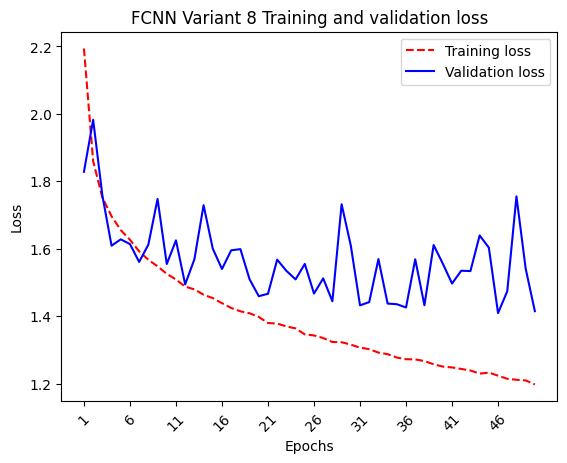

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_8.history["loss"]
val_loss = history_8.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 8 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 8 notes: Overfitting significantly reduces with drop out indicating that model was a little bit too complex. Since drop out was set to 0.5, we remove all drop outs and reduce the number of neurons per hidden layer by half.

In [ ]:
model_8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,979,414 (7.55 MB)

 Trainable params: 988,682 (3.77 MB)

 Non-trainable params: 2,048 (8.00 KB)

 Optimizer params: 988,684 (3.77 MB)

### Variant 9 = (Dense, 128,batchnorm,relu)-(Dense,128,batchnorm,relu)-(Dense,128,batchnorm,relu)-(Dense,128,batchnorm,relu)-(Dense,10,softmax)
###Compilation = {optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers

#structure definition
model_9 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),

     layers.Dense(128,name='dense_1'),
     layers.BatchNormalization(name='bn_1'),
     layers.ReLU(name='relu_1'),
     #layers.Dropout(0.5),

     layers.Dense(128,name='dense_2'),
     layers.BatchNormalization(name='bn_2'),
     layers.ReLU(name='relu_2'),
     #layers.Dropout(0.5),

     layers.Dense(128,name='dense_3'),
     layers.BatchNormalization(name='bn_3'),
     layers.ReLU(name='relu_3'),
     #layers.Dropout(0.5),

     layers.Dense(128,name='dense_4'),
     layers.BatchNormalization(name='bn_4'),
     layers.ReLU(name='relu_4'),
     #layers.Dropout(0.5),

     layers.Dense(10, activation='softmax',name='preds')
     ]
)


opt = keras.optimizers.RMSprop()
model_9.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_9 = model_9.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_9.save('FCNN_Variant_9.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3936 - loss: 1.6997 - val_accuracy: 0.3229 - val_loss: 1.9066
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4783 - loss: 1.4622 - val_accuracy: 0.3881 - val_loss: 1.7340
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5150 - loss: 1.3560 - val_accuracy: 0.3853 - val_loss: 1.7939
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5430 - loss: 1.2756 - val_accuracy: 0.3541 - val_loss: 1.9365
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5709 - loss: 1.1996 - val_accuracy: 0.4090 - val_loss: 1.6616
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5928 - loss: 1.1400 - val_accuracy: 0.4423 - val_loss: 1.6260
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6119 - loss: 1.0854 - val_accuracy: 0.4212 - val_loss: 1.7900
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6315 - loss: 1.0366 - val_accuracy: 0.

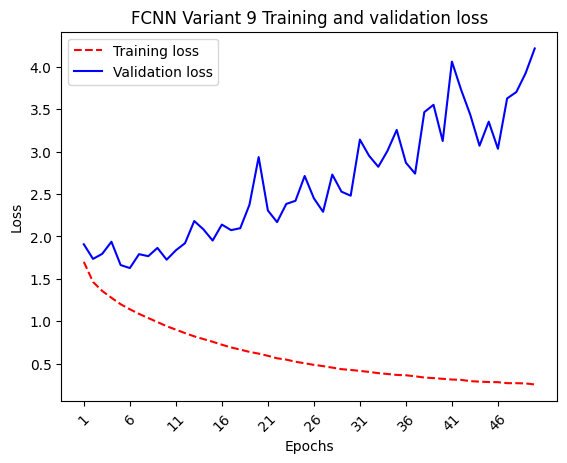

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_9.history["loss"]
val_loss = history_9.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 9 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 9 notes: Removing Dropout and reducing the number neurons per layer caused overfitting, however, training performance improved in comparison to variant 8. Next, we employ l1 regularization to see if it produces better results than dropout. We choose l1 because it has the capability to push irrelevant weights to zero, essentially acting as dropout without randomization

In [ ]:
model_9.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 891,414 (3.40 MB)

 Trainable params: 445,194 (1.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 445,196 (1.70 MB)

### Variant 10 = (Dense, 128,batchnorm,relu, L1)-(Dense,128,batchnorm,relu, L1)-(Dense,128,batchnorm,relu, L1)-(Dense,128,batchnorm,relu, L1)-(Dense,10,softmax)
###Compilation = {optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy',  metrics = ['accuracy']}
###Fitting = {batch_size=128, epochs=50, validation_split = 0.2}

In [ ]:
from keras import models, layers, regularizers

#structure definition
model_10 = keras.Sequential(
    [layers.Input(shape=(32,32,3), name='input'),
     layers.Flatten(name='flatten'),

     layers.Dense(128, kernel_regularizer= regularizers.L1(1e-5),name='dense_1'),
     layers.BatchNormalization(name='bn_1'),
     layers.ReLU(name='relu_1'),
     #layers.Dropout(0.5),

     layers.Dense(128, kernel_regularizer= regularizers.L1(1e-5),name='dense_2'),
     layers.BatchNormalization(name='bn_2'),
     layers.ReLU(name='relu_2'),
     #layers.Dropout(0.5),

     layers.Dense(128, kernel_regularizer= regularizers.L1(1e-5),name='dense_3'),
     layers.BatchNormalization(name='bn_3'),
     layers.ReLU(name='relu_3'),
     #layers.Dropout(0.5),

     layers.Dense(128, kernel_regularizer= regularizers.L1(1e-5),name='dense_4'),
     layers.BatchNormalization(name='bn_4'),
     layers.ReLU(name='relu_4'),
     #layers.Dropout(0.5),

     layers.Dense(10, activation='softmax',name='preds')
     ]
)


opt = keras.optimizers.RMSprop()
model_10.compile(optimizer= opt,
              loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'] #  keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')
              )

history_10 = model_10.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=50,
    validation_split = 0.2)

model_10.save('FCNN_Variant_10.keras')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3950 - loss: 1.8191 - val_accuracy: 0.3554 - val_loss: 1.9668
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4783 - loss: 1.5915 - val_accuracy: 0.3261 - val_loss: 2.0648
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5169 - loss: 1.4928 - val_accuracy: 0.3981 - val_loss: 1.8470
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5433 - loss: 1.4162 - val_accuracy: 0.3824 - val_loss: 1.9234
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5685 - loss: 1.3554 - val_accuracy: 0.3943 - val_loss: 1.8770
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5861 - loss: 1.3058 - val_accuracy: 0.3683 - val_loss: 2.0070
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6065 - loss: 1.2556 - val_accuracy: 0.3375 - val_loss: 2.3122
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6195 - loss: 1.2153 - val_accuracy: 0.

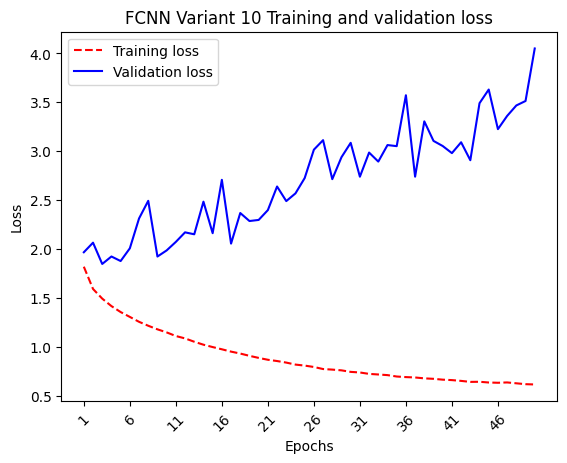

In [ ]:
import matplotlib.pyplot as plt


#training vs accuracy loss
loss = history_10.history["loss"]
val_loss = history_10.history["val_loss"]
epochs = range(       1, len(loss) + 1)
plt.plot(epochs, loss, "r--", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("FCNN Variant 10 Training and validation loss")
plt.xlabel("Epochs")
plt.xticks(epochs[::5], rotation=45)
plt.ylabel("Loss")
plt.legend()
plt.show()

# top 3 training vs validaton accuracy


####Variant 10 notes:

####Variant 10 notes: Model is overfitting off rip

In [ ]:
model_10.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_1 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_2 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_3 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_4 (ReLU)                   │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preds (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 891,414 (3.40 MB)

 Trainable params: 445,194 (1.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 445,196 (1.70 MB)

#Final Evaluations

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.losses import SparseCategoricalCrossentropy

In [ ]:
y_pred_logits = model_5.predict(x_test)
y_pred = np.argmax(y_pred_logits, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

loss_fn = SparseCategoricalCrossentropy(from_logits=True)   # set False if your model ends with softmax
loss = loss_fn(y_test, y_pred_logits)

print("Loss:      ", loss)
print("Accuracy:  ", accuracy)
print("Precision: ", precision)
print("Recall:    ", recall)
print("F1 Score:  ", f1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step
Loss:       1.9870646
Accuracy:   0.516
Precision:  0.5318714603316231
Recall:     0.516
F1 Score:   0.5154940814709237
